# 词向量探索之旅

### 环境准备

确保已将 `histwords` 目录加入 `PYTHONPATH`，并已安装依赖。


In [41]:
import sys
sys.path.append('/root/data/MicroDistance-Word2Vec/histwords')
import pickle
import numpy as np
from itertools import combinations
from numpy.linalg import norm
from representations.sequentialembedding import SequentialEmbedding
from representations.embedding import Embedding

# 设置打印选项，以模拟旧版本的行为
np.set_printoptions(legacy='1.21')

## 1. 从斯坦福大学HistWords项目中获取词向量

In [42]:
import pickle
import numpy as np

# 加载词表
with open('/root/data/MicroDistance-Word2Vec/Chinese_sgns_basic/1990-vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

# 加载词向量
vecs = np.load('/root/data/MicroDistance-Word2Vec/Chinese_sgns_basic/1990-w.npy')

# 获取某个词的向量
words = ['病毒', '电脑', '疾病', '计算机']
for word in words:
    if word in vocab:
        idx = vocab.index(word)
        vector = vecs[idx]
        print(vector.shape) # 输出向量维度
    else:
        print('词不在词表中')
        


(300,)
(300,)
(300,)
(300,)


In [43]:
from itertools import combinations
from numpy.linalg import norm

# 获取所有在词表中的词及其向量
word_vecs = {}
for word in words:
    if word in vocab:
        idx = vocab.index(word)
        word_vecs[word] = vecs[idx]

# 计算两两余弦相似度
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

for w1, w2 in combinations(word_vecs.keys(), 2):
    sim = cosine_similarity(word_vecs[w1], word_vecs[w2])
    print(f"{w1} - {w2} 的余弦相似度: {sim:.4f}")


病毒 - 电脑 的余弦相似度: 0.2628
病毒 - 疾病 的余弦相似度: 0.3643
病毒 - 计算机 的余弦相似度: 0.3050
电脑 - 疾病 的余弦相似度: 0.1756
电脑 - 计算机 的余弦相似度: 0.4383
疾病 - 计算机 的余弦相似度: 0.1918


## 调用HistWords提供的API端口

In [44]:
from representations.sequentialembedding import SequentialEmbedding
from representations.embedding import Embedding
# SequentialEmbedding是Word2Vec（SGNS）词向量
# Embedding是SVD词向量

# 加载词向量：单一时间点
embedding = Embedding.load('/root/data/MicroDistance-Word2Vec/Chinese_sgns_basic/1990')
# 获取词向量
vector = embedding.represent('病毒')
print(vector.shape)

(300,)


In [45]:
neighbors = embedding.closest('学者', n=5)
for score, word in neighbors:
    print(word, score)

学者 0.9999999999999999
专家 0.6019439454234679
名望 0.5160167174959029
业内 0.49601799256692675
与会 0.45654864865628536


## 历史模型

In [46]:
### 3.1 加载历史词向量序列

from representations.sequentialembedding import SequentialEmbedding
years = range(1950, 2000, 10)
semb = SequentialEmbedding.load('/root/data/MicroDistance-Word2Vec/chi-sim-all/sgns', years)

In [47]:
### 3.2 获取某一年份的 Embedding

embed_1990 = semb.get_embed(1990)

In [48]:
### 3.3 获取某个词在各年份的向量

for year in years:
    vec = semb.get_embed(year).represent('主义')
    print(year, vec[:5])

1950 [-0.04487927  0.02573186 -0.00947995 -0.03877381  0.03205856]
1960 [ 0.00161559  0.04229061 -0.0445441  -0.02257752  0.06220378]
1970 [-0.00346575  0.0531096  -0.09491494 -0.03063736  0.01986805]
1980 [-0.00850022 -0.02292808 -0.06003177 -0.04335207  0.04974374]
1990 [-0.01324701  0.0365957   0.01875553 -0.0736503   0.09564648]


In [49]:
### 3.4 计算某两个词随时间的相似度变化

time_sims = semb.get_time_sims('学术', '反动')
for year, sim in time_sims.items():
    print(year, sim)

1950 0.4552571961323729
1960 0.4420168275879869
1970 0.1762702730146145
1980 0.12860420820157537
1990 0.1581925143538493


In [50]:
### 3.5 获取某个词在所有年份的邻居集合

neigh_set = semb.get_seq_neighbour_set('反动', n=2)
print(neigh_set)

{'残酷', '流毒', '猖狂', '资产', '反动', '腐朽'}


## 读取词性

In [51]:
import pickle

pos_file = '/root/data/MicroDistance-Word2Vec/chi-sim-all/pos/1990-pos.pkl'
with open(pos_file, 'rb') as f:
    pos_dict = pickle.load(f)

# 示例：提取指定词的词性
target_words = ['文人', '作家', '反动']
for word in target_words:
    print(f"{word}: {pos_dict.get(word, '未知')}")

文人: NOUN
作家: NOUN
反动: ADJ


### 词性标签表

| 类别       | NOUN | VERB | ADV | ADJ | PRT           | NUM |
|------------|------|------|-----|------|---------|-----|
| 含义 | 名词 | 动词 | 副词 | 形容词 | 小品词| 数词 |



In [52]:
# 按照词性筛选邻居

def get_neighbor_with_pos(embed: Embedding, pos_dict: dict, target_word: str, target_pos: str, n=10):
    """
    获取与 target_word 最相近且词性为 target_pos 的前 n 个词。
    """
    # 获取所有邻居及分数
    neighbors = embed.closest(target_word, n=n*5)  # 先多取一些，防止词性过滤后不够
    filtered = []
    for score, word in neighbors:
        if pos_dict.get(word) == target_pos:
            filtered.append((score, word))
        if len(filtered) >= n:
            break
    return filtered


In [53]:
# 示例用法：
result = get_neighbor_with_pos(embedding, pos_dict, '反动', 'NOUN', n=5)
for score, word in result:
    print(word, score)

流毒 0.4868973151790801
统治 0.469506656018562
反动派 0.4544083060623153
山头 0.4390510906423339
势力 0.4244963574685242


In [54]:
# 获取历年的邻居集合（不筛选词性）

semb.get_seq_closest_by_year("钱", n=5)

{1950: [(0.9999999999999998, '钱'),
  (0.9038659420271383, '花'),
  (0.835149942616815, '人家'),
  (0.8337984704298391, '买'),
  (0.8294886079513678, '吃')],
 1960: [(1.0, '钱'),
  (0.7650870282192708, '花'),
  (0.7129815339097929, '一声'),
  (0.6971985912410859, '口气'),
  (0.6760362568782627, '这儿')],
 1970: [(0.9999999999999993, '钱'),
  (0.5850082522695432, '买'),
  (0.5524397898584145, '笔'),
  (0.5367441157010124, '花'),
  (0.5156797911524045, '力气')],
 1980: [(1.0, '钱'),
  (0.5349853096138412, '赚'),
  (0.5055068782570069, '花'),
  (0.47393366638954987, '袋'),
  (0.471501573268131, '琛')],
 1990: [(1.0, '钱'),
  (0.4587084023580492, '袋'),
  (0.45845257084407204, '掏'),
  (0.44759882378635524, '赚'),
  (0.4351914162230578, '抽屉')]}

In [55]:
def get_seq_neighbor_with_pos(seqembed: SequentialEmbedding, pos_dict: dict, target_word: str, target_pos: str, n=10):
    """
    获取目标词在每个年份中，最相近且词性为 target_pos 的前 n 个词。
    返回格式：{year: [(score, word), ...], ...}
    """
    result = {}
    for year, embed in seqembed.embeds.items():
        neighbors = embed.closest(target_word, n=n*100)  # 先多取一些
        filtered = []
        for score, word in neighbors:
            if pos_dict.get(word) == target_pos and word != target_word and score > 0.0:
                filtered.append((score, word))
            if len(filtered) >= n:
                break
        result[year] = filtered
    return result

In [56]:
# 示例用法
get_seq_neighbor_with_pos(semb, pos_dict, "钱", "ADJ", n=5)

{1950: [(0.7484916568501956, '年轻'),
  (0.698449745027883, '女'),
  (0.5980052306407435, '亲爱'),
  (0.5614793955077362, '违法'),
  (0.5436568614143564, '间接')],
 1960: [(0.5316574658520359, '女'),
  (0.5078091283696169, '年轻'),
  (0.4924626804071737, '相关'),
  (0.4663310115925252, '亲爱'),
  (0.4641558590600444, '有限')],
 1970: [(0.4098309110734928, '男'),
  (0.3945802598299771, '女'),
  (0.3754188716391379, '年轻'),
  (0.3684000505355881, '优质'),
  (0.35792361677380874, '可怜')],
 1980: [(0.3748411423736513, '巨额')],
 1990: [(0.2683090578396913, '余下')]}

## 读取词频（如果你需要的话）

In [57]:
counts_file = '/root/data/MicroDistance-Word2Vec/chi-sim-all/counts/1990-counts.pkl'
with open(counts_file, 'rb') as f:
    counts_dict = pickle.load(f, encoding='latin1') # 考虑到是python2时代保存的pickle文件，应该用latin1读取避免历史遗留问题

# 示例：提取指定词的词频
target_words = ['文人', '作家', '反动']
for word in target_words:
    print(f"{word}: {counts_dict.get(word, '未知')}")
    
# 如果你需要读取多个年代的词频，可自行编写相关代码

文人: 2076.0
作家: 210922.5
反动: 44264.5


## 加载数据集代码总结

In [58]:
# 如果读取单个时间点的数据：

# from representations.embedding import Embedding
# from representations.sequentialembedding import SequentialEmbedding

# embedding = Embedding.load('这里放你的路径')


# 如果读取多个时间点的数据：

# years = range(1950, 2000, 10) # 这里放年份列表
# semb = SequentialEmbedding.load('这里放你的文件夹路径', years)

## 英文数据集的加载也同理

In [59]:
from representations.sequentialembedding import SequentialEmbedding
from representations.embedding import Embedding

years = range(1870,2000,10)
seq_embedding_eng = SequentialEmbedding.load('/root/data/MicroDistance-Word2Vec/eng-all/sgns',years)
# 加载比较慢，要忍一下

In [60]:
seq_embedding_eng.get_seq_closest_by_year("sociology", n=5)

{1870: [(1.0000000000000004, 'sociology'),
  (0.45738268155866996, 'psychology'),
  (0.4284553286666483, 'biology'),
  (0.3955207929883868, 'physics'),
  (0.3889117574623539, 'philosophy')],
 1880: [(1.0000000000000004, 'sociology'),
  (0.5206331713820916, 'psychology'),
  (0.48180821961133424, 'sociological'),
  (0.47213954248242496, 'biology'),
  (0.43168598598776076, 'sidgwick')],
 1890: [(1.0000000000000004, 'sociology'),
  (0.5419322320173293, 'psychology'),
  (0.5191617896655658, 'economics'),
  (0.48799267611985453, 'biology'),
  (0.4682739507841084, 'science')],
 1900: [(0.9999999999999997, 'sociology'),
  (0.6100873679120147, 'civics'),
  (0.59094659142378, 'economics'),
  (0.5803837226064144, 'psychology'),
  (0.5774356863991916, 'ethics')],
 1910: [(1.0000000000000004, 'sociology'),
  (0.5445923625400886, 'economics'),
  (0.5195963119072255, 'anthropology'),
  (0.5128836317115731, 'psychology'),
  (0.4924609243782271, 'ethics')],
 1920: [(0.9999999999999999, 'sociology'),
  

In [61]:
eng_pos_file = '/root/data/MicroDistance-Word2Vec/eng-all/pos/1990-pos.pkl'
with open(eng_pos_file, 'rb') as f:
    eng_pos = pickle.load(f)

In [62]:
get_seq_neighbor_with_pos(seq_embedding_eng, eng_pos, 'sociology', 'ADJ', n=5)

{1870: [(0.35396117824294476, 'synthetic'),
  (0.352586732384496, 'magnetical'),
  (0.3365772650087527, 'polynesian'),
  (0.33645846555943804, 'darwinian'),
  (0.3325209577026794, 'biological')],
 1880: [(0.48180821961133424, 'sociological'),
  (0.40461391444439576, 'tactical'),
  (0.3591098137057118, 'theoretical'),
  (0.3551789340377014, 'psychological'),
  (0.35510544010823736, 'baconian')],
 1890: [(0.36518730565540414, 'psychological'),
  (0.3604906521603737, 'pedagogical'),
  (0.3369769272075456, 'biblical'),
  (0.33664236707334705, 'institutional'),
  (0.33576709094265744, 'political')],
 1900: [(0.3994272830241079, 'dynamic'),
  (0.38084152411844663, 'economic'),
  (0.3688548442798771, 'biological'),
  (0.36026568760270666, 'psychological'),
  (0.3563949067624349, 'humanistic')],
 1910: [(0.36514229107079077, 'political'),
  (0.3552880709011025, 'sociological'),
  (0.3449275269370676, 'dynamic'),
  (0.34312185374647897, 'social'),
  (0.33994407546445915, 'psychological')],
 192

In [63]:
import matplotlib.pyplot as plt

def plot_cosine_similarity(trend):
    plt.plot(list(trend.keys()), list(trend.values()), marker='o')
    plt.xlabel('Year')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


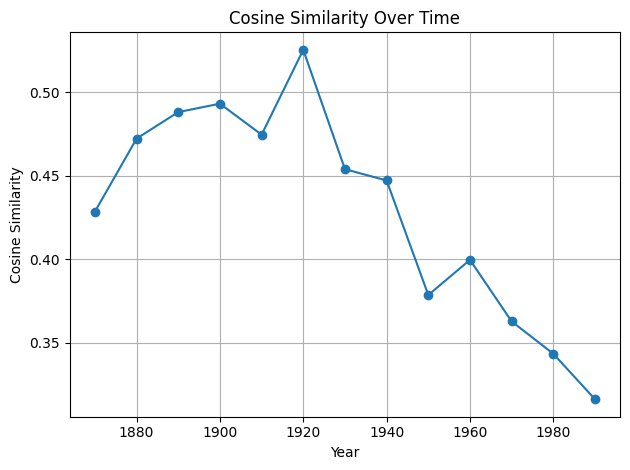

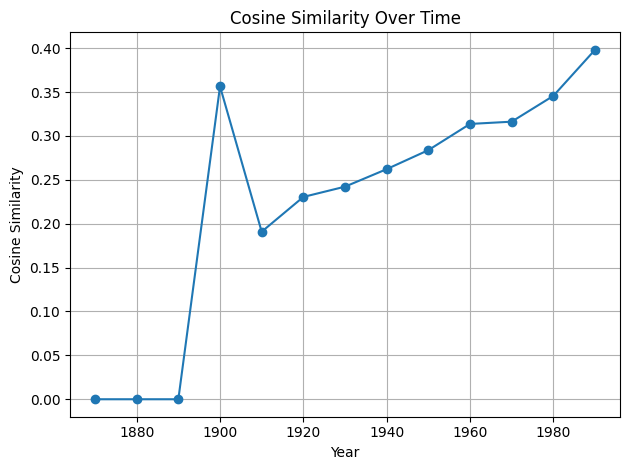

In [64]:
sims = seq_embedding_eng.get_time_sims('sociology','biology')
plot_cosine_similarity(sims)

sims = seq_embedding_eng.get_time_sims('sociology','humanistic')
plot_cosine_similarity(sims)


In [65]:
occupations = [
    "doctor", "lawyer", "teacher", "engineer", "nurse", "dentist", "accountant", "architect", "chemist", "scientist",
    "pilot", "farmer", "writer", "poet", "actor", "singer", "dancer", "musician", "painter", "sculptor",
    "tailor", "baker", "butcher", "barber", "clerk", "cashier", "waiter", "porter", "cook", "janitor",
    "soldier", "sailor", "captain", "guard", "officer", "detective", "judge", "minister", "priest", "monk",
    "hunter", "fisher", "miller", "weaver", "potter", "brewer", "carpenter", "mason", "plumber", "electrician",
    "mechanic", "driver", "miner", "merchant", "trader", "banker", "broker", "editor", "reporter", "librarian",
    "student", "scholar", "professor", "lecturer", "researcher", "mathematician", "physicist", "biologist", "geologist", "astronomer",
    "pharmacist", "optician", "surgeon", "therapist", "psychologist", "psychiatrist", "midwife", "paramedic", "firefighter", "policeman",
    "judge", "lawman", "warden", "blacksmith", "shoemaker", "tailor", "cobbler", "gardener", "cleaner", "washer",
    "vendor", "peddler", "bartender", "host", "usher", "receptionist", "clergyman", "chaplain", "bellhop", "waitress"
]

occupations_vecs = []

embed_1990 = seq_embedding_eng.get_embed(1990)

for occupation in occupations:
    vec = embed_1990.represent(occupation)
    occupations_vecs.append((occupation, vec))

('OOV: ', 'paramedic')
('OOV: ', 'firefighter')
('OOV: ', 'lawman')
('OOV: ', 'bellhop')


In [66]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
def reduce_dims(words_vecs, method="pca"):
    """
    接收一个包含 (word, vector) 元组的列表，返回 DataFrame 结果
    参数：
        words_vecs: List[Tuple[str, np.ndarray]]
        method: "pca" 或 "tsne"
    返回：
        pd.DataFrame，包含列 ["word", "X", "Y"]
    """
    names = [item[0] for item in words_vecs]
    vecs = np.stack([item[1] for item in words_vecs])

    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    vecs_2d = reducer.fit_transform(vecs)
    return pd.DataFrame({"word": names, "X": vecs_2d[:, 0], "Y": vecs_2d[:, 1]})



In [67]:
import matplotlib.pyplot as plt

def plot_hexbin(df_proj, cmap="Blues"):
    """
    可视化二维向量（hexbin）
    参数：
        df_proj: DataFrame，包含列 ["word", "X", "Y"]
        cmap: 字符串，matplotlib colormap 名称
    """
    plt.figure(figsize=(6, 5))
    plt.hexbin(df_proj["X"], df_proj["Y"], cmap=cmap, gridsize=20, linewidths=0)
    plt.title("Projection")
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()


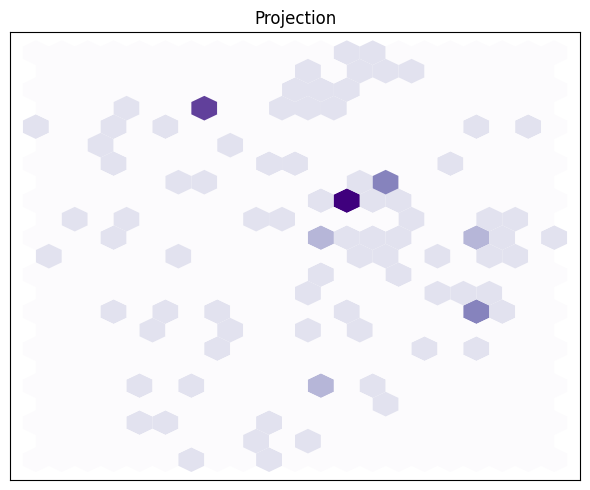

In [68]:
df_proj = reduce_dims(occupations_vecs, method="pca")  # 或 method="tsne"
plot_hexbin(df_proj, cmap="Purples")


In [69]:
from sklearn.cluster import KMeans

def cluster_occupations(occupations_vecs, n_clusters=6):
    """
    对职业向量进行 KMeans 聚类
    参数：
        occupations_vecs: List[Tuple[str, np.ndarray]]
        n_clusters: 聚类数量（默认 6）
    返回：
        pd.DataFrame，包含 occupation、X、Y、cluster 三列
    """
    names = [item[0] for item in occupations_vecs]
    vecs = np.stack([item[1] for item in occupations_vecs])

    # 降维到 2D 方便可视化
    pca = PCA(n_components=2)
    vecs_2d = pca.fit_transform(vecs)

    # 聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(vecs)

    df = pd.DataFrame({
        "occupation": names,
        "X": vecs_2d[:, 0],
        "Y": vecs_2d[:, 1],
        "cluster": clusters
    })

    return df, kmeans


In [70]:
def plot_clusters_with_labels(df_proj):
    """
    可视化聚类结果，带职业名称标注
    参数：
        df_proj: 包含 occupation、X、Y、cluster 列的 DataFrame
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_proj["X"], df_proj["Y"], c=df_proj["cluster"],
                          cmap="tab10", s=60, alpha=0.8)

    # 添加职业名称文本
    for _, row in df_proj.iterrows():
        plt.text(row["X"] + 0.01, row["Y"] + 0.01, row["occupation"],
                 fontsize=8, alpha=0.75)

    plt.title("Occupation Clusters with Labels")
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()


   occupation  cluster
       farmer        0
        baker        0
       barber        0
         cook        0
       porter        0
      butcher        0
        miner        0
       editor        0
       hunter        0
       fisher        0
       miller        0
       weaver        0
       potter        0
       brewer        0
    carpenter        0
        mason        0
       lawman        0
       warden        0
   blacksmith        0
    shoemaker        0
      cobbler        0
      bellhop        0
      peddler        0
       washer        0
  firefighter        0
    paramedic        0
     optician        0
     minister        1
      officer        1
        guard        1
       driver        1
      captain        1
  electrician        1
       tailor        1
      surgeon        1
    policeman        1
        judge        1
        judge        1
        pilot        1
     engineer        1
       tailor        1
        clerk        1
      cashi

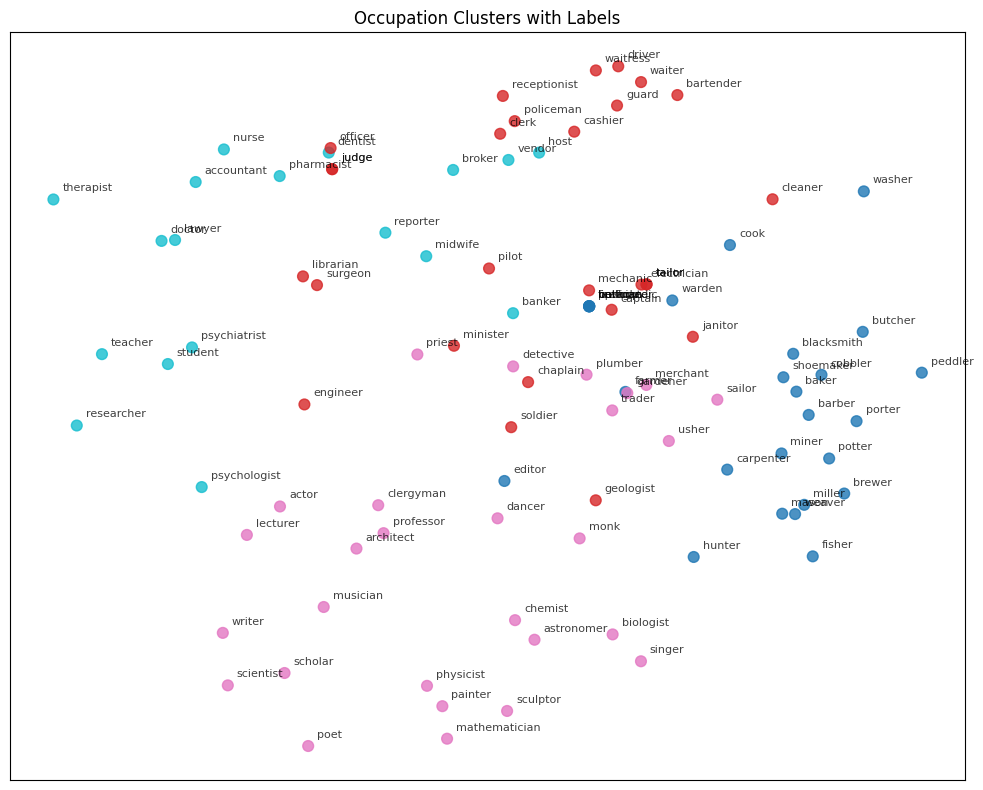

In [71]:
df_clustered, kmeans_model = cluster_occupations(occupations_vecs, n_clusters=4)

# 从聚类后的 DataFrame 中提取职业名和聚类标签
df_result = df_clustered[["occupation", "cluster"]].sort_values(by="cluster").reset_index(drop=True)

# 输出表格（可选：用于 Jupyter 或脚本）
print(df_result.to_string(index=False))

plot_clusters_with_labels(df_clustered)


In [72]:
def explain_clusters_by_center_words(kmeans_model, embed_model, topn=10):
    """
    输出每个聚类中心最接近的 topn 个词，用于语义解释
    参数：
        kmeans_model: 训练好的 KMeans 模型（含 cluster_centers_）
        embed_model: 你自己的嵌入模型对象（需实现 vec_closest 方法）
        topn: 每个聚类中心返回几个词
    返回：
        dict[int, list[str]]，键是 cluster_id，值是代表词列表
    """
    explanations = {}
    for i, center in enumerate(kmeans_model.cluster_centers_):
        # 确保聚类中心也被归一化
        norm_center = center / np.linalg.norm(center)
        words = embed_model.vec_closest(norm_center, n=topn)
        explanations[i] = [word for score, word in words]
    return explanations



In [73]:
explain_clusters_by_center_words(kmeans_model, embed_1990)

{0: ['teitelbaum',
  'kellerman',
  'strother',
  'chauncy',
  'neilson',
  'kenton',
  'winton',
  'macrae',
  'ewan',
  'blakely'],
 1: ['clerk',
  'officer',
  'engineer',
  'surgeon',
  'policeman',
  'captain',
  'sheriff',
  'sergeant',
  'assistant',
  'soldier'],
 2: ['musician',
  'painter',
  'poet',
  'scholar',
  'sculptor',
  'scientist',
  'mathematician',
  'novelist',
  'clergyman',
  'composer'],
 3: ['psychiatrist',
  'physician',
  'lawyer',
  'nurse',
  'doctor',
  'pharmacist',
  'therapist',
  'practitioner',
  'psychologist',
  'accountant']}

In [74]:
# 试一下乱玩能不能玩出什么...

# 比如，取中点

vec1 = embed_1990.represent("man")
vec2 = embed_1990.represent("woman")
vec_m = (vec1 + vec2)/2
vec_m = vec_m / np.linalg.norm(vec_m)

# embed_1990.vec_closest(vec_m)

# 再比如，取加减法

vec1 = embed_1990.represent("king")
vec2 = embed_1990.represent("woman")
vec3 = embed_1990.represent("man")
vec_result = vec1 + vec2 - vec3
vec_result = vec_result / np.linalg.norm(vec_result)

# embed_1990.vec_closest(vec_result)

vec = embed_1990.represent("china") + embed_1990.represent("capital")
vec = vec / np.linalg.norm(vec)
# embed_1990.vec_closest(vec)

vecs = [embed_1990.represent(w) for w in ["poet", "painter", "musician", "dancer", "actor"]]
vec = np.mean(vecs, axis=0)
vec = vec / np.linalg.norm(vec)
# embed_1990.vec_closest(vec)

vec = embed_1990.represent("man")
# embed_1990.vec_closest(-vec)

vec = embed_1990.represent("communism") + embed_1990.represent("usa") - embed_1990.represent("china")
vec = vec / np.linalg.norm(vec)
# embed_1990.vec_closest(vec)


In [75]:
def project_on_axis(word_list, positive_end, negative_end, embed):
    def avg_vector(words):
        vecs = []
        for w in words:
            try:
                vec = embed.represent(w)
                vecs.append(vec / np.linalg.norm(vec))
            except KeyError:
                continue
        return np.mean(vecs, axis=0)

    pos_vec = avg_vector(positive_end)
    neg_vec = avg_vector(negative_end)
    axis_center = (pos_vec + neg_vec) / 2
    axis_dir = pos_vec - neg_vec
    axis_dir = axis_dir / np.linalg.norm(axis_dir)

    results = []
    for word in word_list:
        try:
            vec = embed.represent(word)
            vec = vec / np.linalg.norm(vec)
            # 投影是相对于轴中心的位移
            offset = vec - axis_center
            score = np.dot(offset, axis_dir)
            results.append((word, score))
        except KeyError:
            continue

    return sorted(results, key=lambda x: -x[1])


In [76]:
positive_end = ["rich", "wealthy", "affluent"]
negative_end = ["poor", "needy", "destitute"]
targets = ["banker", "lawyer", "farmer", "poet", "beggar", "merchant"]

scores = project_on_axis(targets, positive_end, negative_end, embed_1990)

for word, score in scores:
    print(f"{word:10} {score:.3f}")


merchant   0.213
poet       0.202
banker     0.183
lawyer     0.174
farmer     0.082
beggar     -0.044


## 降维可视化

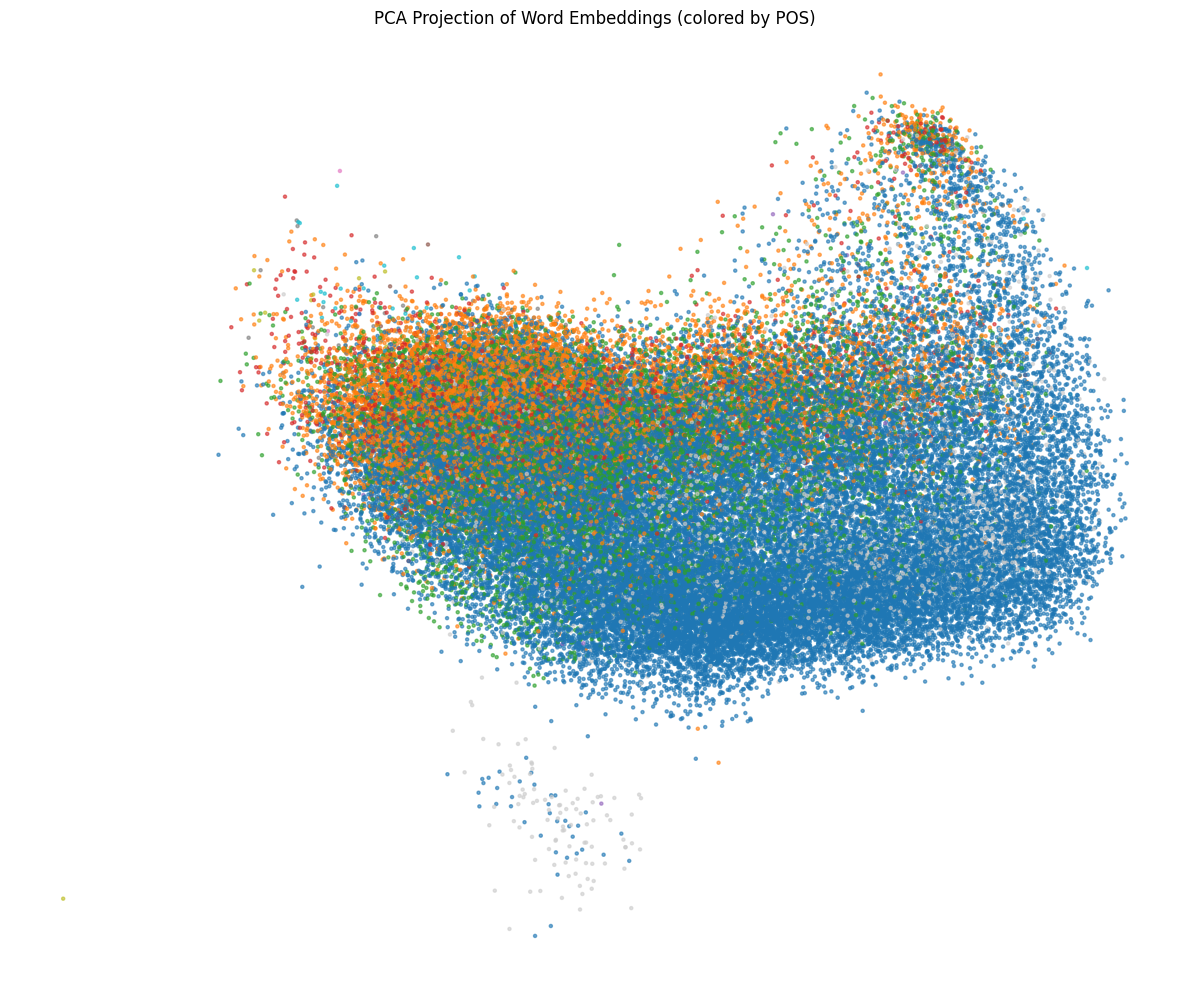

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Step 1: 提取词和向量
embed = embed_1990
words = embed.iw
vecs = embed.m

# Step 2: 清洗词，排除非单词 + 没有词性的
def is_valid_word(w):
    return w.isalpha() and w in eng_pos and 2 <= len(w) <= 15

filtered = [(w, v, eng_pos[w]) for w, v in zip(words, vecs) if is_valid_word(w)]
if not filtered:
    raise ValueError("没有找到符合条件的词！")

filtered_words = [w for w, _, _ in filtered]
filtered_vecs = np.stack([v for _, v, _ in filtered])
filtered_pos = [pos for _, _, pos in filtered]

# Step 3: 归一化向量
vecs_normed = normalize(filtered_vecs)

# Step 4: PCA 降维
pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(vecs_normed)

# Step 5: 放入 DataFrame
df_proj = pd.DataFrame({
    "word": filtered_words,
    "x": vecs_2d[:, 0],
    "y": vecs_2d[:, 1],
    "pos": filtered_pos
})

# Step 6: 定义颜色映射（自定义常见词性颜色）
color_map = {
    "NOUN": "#1f77b4",  # 蓝
    "VERB": "#ff7f0e",  # 橙
    "ADJ": "#2ca02c",   # 绿
    "ADV": "#d62728",   # 红
    "NUM": "#9467bd",   # 紫
    "PRT": "#8c564b",   # 棕
    "CONJ": "#e377c2",  # 粉
    "ADP": "#7f7f7f",   # 灰
    "DET": "#bcbd22",   # 黄绿
    "PRON": "#17becf",  # 青
}

df_proj["color"] = df_proj["pos"].map(lambda p: color_map.get(p, "#cccccc"))

# Step 7: 可视化（散点图 + 标签）
plt.figure(figsize=(12, 10))
plt.scatter(df_proj["x"], df_proj["y"], c=df_proj["color"], s=5, alpha=0.6)

# 只标注前 1000 个词（可调）
# for i in range(min(1000, len(df_proj))):
#     plt.text(df_proj.loc[i, "x"], df_proj.loc[i, "y"], df_proj.loc[i, "word"],
#              fontsize=6, alpha=0.6)

plt.title("PCA Projection of Word Embeddings (colored by POS)")
plt.axis('off')
plt.tight_layout()
plt.show()


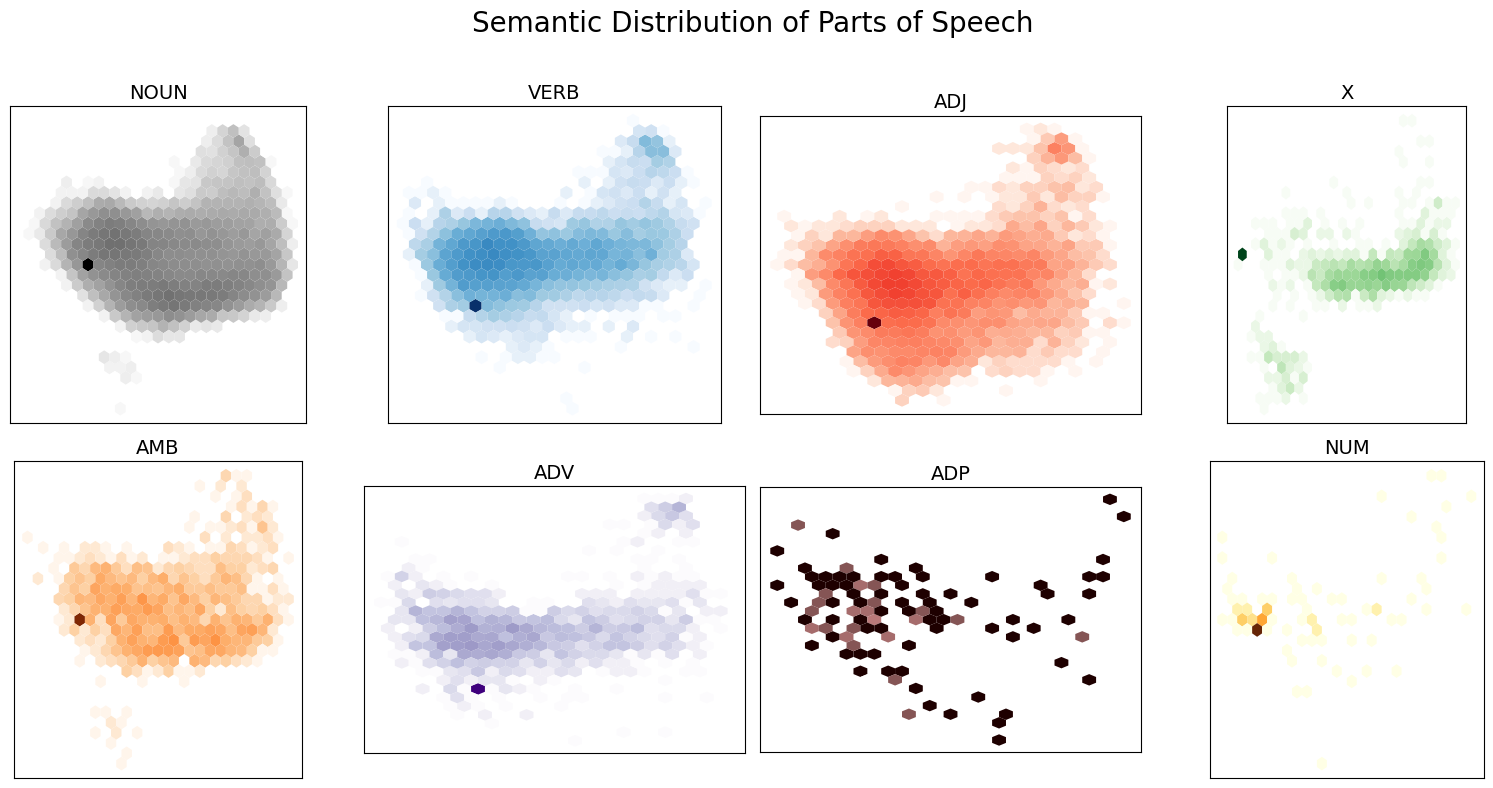

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm


# Step 1 & 2: 数据准备和降维 (与之前相同)
def is_valid_word(w):
    return w.isalpha() and w in eng_pos and 2 <= len(w) <= 20

words, vecs = embed.iw, embed.m
filtered = [(w, v, eng_pos[w]) for w, v in zip(words, vecs) if is_valid_word(w)]
filtered_words, filtered_vecs, filtered_pos = [f[0] for f in filtered], np.stack([f[1] for f in filtered]), [f[2] for f in filtered]
vecs_normed = normalize(filtered_vecs)
pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(vecs_normed)

# 创建最终的 DataFrame
df = pd.DataFrame({
    "word": filtered_words,
    "x": vecs_2d[:, 0],
    "y": vecs_2d[:, 1],
    "pos": filtered_pos
})

# Step 3: 确定要可视化的词性及其对应的颜色图
# 我们可以选择最常见的几个词性来展示
pos_to_plot = df['pos'].value_counts().nlargest(8).index.tolist()

# 为每个词性选择一个基础颜色图 (Colormap)
cmaps = ["Greys", "Blues", "Reds", "Greens", "Oranges", "Purples", "pink", "YlOrBr"]
cmaps = cmaps[:len(pos_to_plot)]


# Step 4: 创建子图并分别绘制 Hexbin 图
# 根据要绘制的词性数量决定网格布局
n_items = len(pos_to_plot)
n_cols = 4
n_rows = (n_items + n_cols - 1) // n_cols # 向上取整计算行数
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten() # 将二维的 axes 数组转换为一维，方便遍历

# 遍历每个词性，在对应的子图上绘图
for i, (pos_label, cmap) in enumerate(zip(pos_to_plot, cmaps)):
    # 筛选出当前词性的数据
    df_sub = df.query(f"pos == '{pos_label}'")
    
    if df_sub.empty:
        axes[i].set_title(f"{pos_label} (No data)")
    else:
        # 在对应的子图上绘制 hexbin
        axes[i].hexbin(
            df_sub["x"],
            df_sub["y"],
            cmap=cmap,
            gridsize=25,    # 可以调整网格大小
            mincnt=1,       # 只有一个点的六边形也进行着色
            norm = LogNorm(),
            linewidths=(0,) # 不绘制六边形的边框
        )
        axes[i].set_title(pos_label, fontsize=14)

    # 隐藏坐标轴刻度
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_aspect('equal') # 保持横纵轴比例一致

# 如果有未使用的子图，将其隐藏
for i in range(len(pos_to_plot), len(axes)):
    axes[i].axis('off')

fig.suptitle("Semantic Distribution of Parts of Speech", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # 调整布局，为大标题留出空间
plt.show()

## 跨语言比较

In [79]:
embed_cn_1990 = semb.get_embed(1990)
embed_eng_1990 = seq_embedding_eng.get_embed(1990)

pos_file_cn = '/root/data/MicroDistance-Word2Vec/chi-sim-all/pos/1990-pos.pkl'
with open(pos_file, 'rb') as f:
    pos_cn = pickle.load(f)
    
pos_file_eng = '/root/data/MicroDistance-Word2Vec/eng-all/pos/1990-pos.pkl'
with open(pos_file_eng, 'rb') as f:
    pos_eng = pickle.load(f)

In [80]:
embed_cn_1990.closest('自由')
embed_eng_1990.closest('liberty')

[(0.9999999999999998, 'liberty'),
 (0.5324857459959338, 'liberties'),
 (0.5064036707791275, 'freedom'),
 (0.4190676892081522, 'freedoms'),
 (0.4140774895492168, 'equality'),
 (0.3789384142992541, 'rights'),
 (0.3769754375024509, 'guarantees'),
 (0.3685880091165215, 'valance'),
 (0.3653586496171596, 'constitutional'),
 (0.35466963210663194, 'deprived')]

In [81]:
get_neighbor_with_pos(embed_cn_1990, pos_cn, '自由', 'ADJ', n=50)

[(0.34756594737555335, '顽固'),
 (0.3428840298183389, '形形色色'),
 (0.3303269378724855, '激进'),
 (0.3001065635249498, '旧式'),
 (0.2871186173282831, '各色'),
 (0.28013324257357836, '复古'),
 (0.2712291571525287, '抽象'),
 (0.2646273488927039, '狭隘')]

In [82]:
get_neighbor_with_pos(embed_eng_1990, pos_eng, 'liberty', 'ADJ', n=30)

[(0.3653586496171596, 'constitutional'),
 (0.3349341907896124, 'indefeasible'),
 (0.31765163742417696, 'inalienable'),
 (0.3084349879345412, 'inviolate'),
 (0.30246811217558417, 'free'),
 (0.2966905914675107, 'right'),
 (0.2909699935004818, 'unfettered'),
 (0.2838689285684085, 'equal'),
 (0.2780863485216283, 'fundamental'),
 (0.27611285485369047, 'inimical'),
 (0.27537467712543, 'sovereign'),
 (0.27457617256845235, 'eternal'),
 (0.2631179584073706, 'indivisible'),
 (0.2623173911007233, 'unborn'),
 (0.2622477324964151, 'personal'),
 (0.253426527779407, 'unprivileged'),
 (0.24703982982747327, 'repugnant'),
 (0.24640752087834863, 'brokenhearted')]

In [83]:
get_neighbor_with_pos(embed_cn_1990, pos_cn, '民主', 'ADJ', n=50)

[(0.34019571777694396, '激进'),
 (0.3329241655477391, '独裁'),
 (0.2983917188564028, '既成'),
 (0.2981010826014001, '旧式'),
 (0.2858888099656549, '爱国'),
 (0.28311655094567, '复古'),
 (0.2770622810730313, '形形色色'),
 (0.27538957130888786, '民选')]

In [84]:
get_neighbor_with_pos(embed_eng_1990, pos_eng, 'democracy', 'ADJ', n=30)

[(0.5204424794305154, 'democratic'),
 (0.3640367819048373, 'liberal'),
 (0.3443326793625881, 'socialist'),
 (0.34208142157699034, 'political'),
 (0.34153931822053535, 'populist'),
 (0.3398620437195472, 'capitalist'),
 (0.3310175063698211, 'laissez'),
 (0.3295325451355243, 'participatory'),
 (0.3263077556557761, 'authoritarian'),
 (0.32162083996492286, 'jeffersonian'),
 (0.32088970333478145, 'bourgeois'),
 (0.31971519142627686, 'economic'),
 (0.31837334423677355, 'parliamentary'),
 (0.313469728061615, 'proletarian'),
 (0.3114703799025655, 'jacksonian'),
 (0.3062981783289847, 'maoist'),
 (0.303192778371667, 'multiparty'),
 (0.300400470792358, 'totalitarian'),
 (0.2992742407306442, 'postwar'),
 (0.29599352603087614, 'electoral'),
 (0.2952237514717341, 'athenian'),
 (0.2940279380985009, 'egalitarian'),
 (0.2927341590722672, 'moldavian'),
 (0.2922951136055568, 'oligarchical'),
 (0.28703883974714534, 'keynesian'),
 (0.2868428111590948, 'impoverished'),
 (0.2849285397654856, 'revolutionary'),

In [85]:
get_seq_neighbor_with_pos(seq_embedding_eng, eng_pos, 'maoist', 'ADJ', n=5)

{1870: [],
 1880: [],
 1890: [],
 1900: [],
 1910: [],
 1920: [],
 1930: [],
 1940: [],
 1950: [],
 1960: [],
 1970: [(0.43367980716809496, 'marxist'),
  (0.41705097934816127, 'leninist'),
  (0.4080652293017447, 'franche'),
  (0.40622006883476847, 'theistic'),
  (0.39063072493620477, 'marxian')],
 1980: [(0.4183848562621729, 'empirio'),
  (0.4150766915334141, 'wilsonian'),
  (0.4120291056955096, 'leninist'),
  (0.4072174759907067, 'canny'),
  (0.40695197205943767, 'menshevik')],
 1990: [(0.5081913570620344, 'leninist'),
  (0.4645057640364335, 'marxist'),
  (0.4403537135773027, 'postwar'),
  (0.4340890838597317, 'fundamentalist'),
  (0.42695959970142083, 'moldavian')]}